# **UNET MODEL**

In [1]:
import numpy as np

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, concatenate, Lambda, add, Activation
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
       # print(os.path.join(dirname, filename))

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as ft
import glob

In [6]:
benign ='Dataset_BUSI_with_GT/benign'
malignant='Dataset_BUSI_with_GT/malignant'
normal='Dataset_BUSI_with_GT/normal'

In [7]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

In [8]:
# Get the list of all the images
bening_cases = glob.glob(benign+ '/*')
malignant_cases =glob.glob(malignant+ '/*')
normal_cases = glob.glob(normal+ '/*')

# An empty list. We will insert the data into this list in (img_path, label) format
exclude=[]
train_data_mask = []
train_data_img=[]
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else :
        train_data_img.append(img)

# Go through all the bening cases. The label for these cases will be 1
for img in bening_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:

    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

In [9]:
train_data_img = sorted(train_data_img)
train_data_mask = sorted(train_data_mask)

In [10]:
len(train_data_img), len(train_data_mask), len(exclude)

(780, 780, 18)

In [11]:
train_data_img[100]

'Dataset_BUSI_with_GT/benign/benign (19).png'

In [12]:
train_data_mask[100]

'Dataset_BUSI_with_GT/benign/benign (19)_mask.png'

In [13]:
images=[]
masks=[]
size_x=128
size_y=128

for every_img_path in train_data_img:
    img=cv2.imread(every_img_path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(size_y, size_x))
    images.append(img)

for every_mask_path in train_data_mask:
    mask=cv2.imread(every_mask_path,0)
    mask=cv2.resize(mask,(size_y,size_x))
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [14]:
x=images/255
y=masks/255

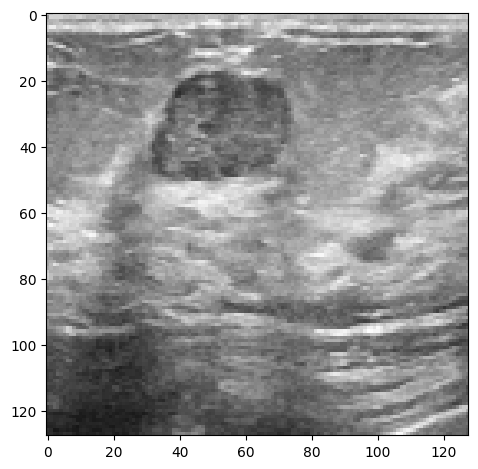

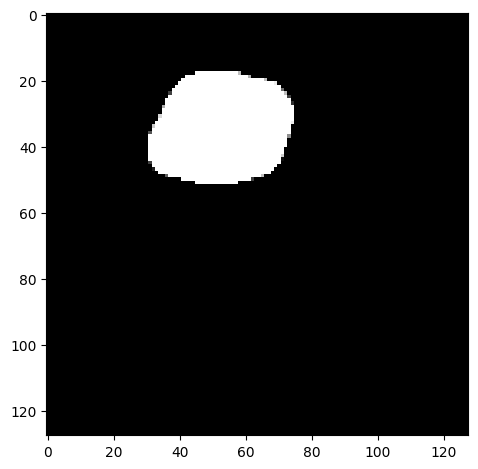

0.08627450980392157 0.996078431372549
(128, 128, 3)
0.0 1.0
(128, 128)


In [15]:
import random
from skimage.io import imshow

########## Displaying random image from X_train and Y_train #########
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show()

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Activation('linear')(outputs)  # Add this line for saliency map


    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [18]:
def get_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Activation('linear')(outputs)  # Add this line for saliency map

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [19]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [21]:
history=model.fit(x_train,
          y_train,
          batch_size=20,
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/50
32/32 [==============================] - 26s 157ms/step - loss: 0.3608 - mse: 0.1017 - val_loss: 0.3000 - val_mse: 0.0803
Epoch 2/50
32/32 [==============================] - 2s 65ms/step - loss: 0.2819 - mse: 0.0736 - val_loss: 0.2577 - val_mse: 0.0685
Epoch 3/50
32/32 [==============================] - 2s 65ms/step - loss: 0.2450 - mse: 0.0655 - val_loss: 0.2672 - val_mse: 0.0684
Epoch 4/50
32/32 [==============================] - 2s 64ms/step - loss: 0.2176 - mse: 0.0619 - val_loss: 0.2205 - val_mse: 0.0592
Epoch 5/50
32/32 [==============================] - 2s 63ms/step - loss: 0.1873 - mse: 0.0509 - val_loss: 0.2409 - val_mse: 0.0619
Epoch 6/50
32/32 [==============================] - 2s 66ms/step - loss: 0.1844 - mse: 0.0514 - val_loss: 0.1933 - val_mse: 0.0522
Epoch 7/50
32/32 [==============================] - 2s 64ms/step - loss: 0.1728 - mse: 0.0472 - val_loss: 0.1730 - val_mse: 0.0477
Epoch 8/50
32/32 [==============================] - 2s 64ms/step - loss: 0.1609 -

In [22]:
import numpy as np

def dice_coef(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union + 1e-5)

def jaccard_index(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection) / (union + 1e-5)

def true_positives_ratio(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    true_positives = np.sum(y_true * y_pred)
    total_positives = np.sum(y_true)
    return (true_positives) / (total_positives + 1e-5)

def false_positives_ratio(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    false_positives = np.sum((1 - y_true) * y_pred)
    total_negatives = np.sum(1 - y_true)
    return (false_positives) / (total_negatives + 1e-5)

def global_accuracy(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    correct_predictions = np.sum((y_true == 1) & (y_pred >= 0.5)) + np.sum((y_true == 0) & (y_pred < 0.5))
    total_predictions = y_true.size
    return (correct_predictions) / (total_predictions + 1e-5)

# Calculate metrics
y_pred = model.predict(x_val)  # Replace with your validation data
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

dsc = dice_coef(y_val, y_pred)
ji = jaccard_index(y_val, y_pred)
tpr = true_positives_ratio(y_val, y_pred)
fpr = false_positives_ratio(y_val, y_pred)
acc = global_accuracy(y_val, y_pred)

print(f"Dice Similarity Coefficient (DSC): {dsc}")
print(f"Jaccard Index (JI): {ji}")
print(f"True Positives Ratio (TPR): {tpr}")
print(f"False Positives Ratio (FPR): {fpr}")
print(f"Global Accuracy (ACC): {acc}")


5/5 [==============================] - 2s 215ms/step
Dice Similarity Coefficient (DSC): 0.7232999079597314
Jaccard Index (JI): 0.5665386197347574
True Positives Ratio (TPR): 0.6646421275570253
False Positives Ratio (FPR): 0.014331674665710208
Global Accuracy (ACC): 0.9600677490196812


https://www.kaggle.com/code/owaistahir/unet-for-breast-cancer-tumors-segmentation
